# SgrA* Comparison: Qmetric
---
This notebook compares Q-metric[1] for synthetic Noisy [2,3] generated movies to SgrA* data. 

**Note the 'dev' branch of ehtim is needed.**

[1] F. Roelofs, M. D. Johnson, H. Shiokawa, S. Doeleman and H. Falacke, Quantifying Intrinsic Variability of Sagittarius A* Using Close Phase Measurements of The Event Horizon Telescope: https://arxiv.org/pdf/1708.01056.pdf

[2] https://github.com/AFD-Illinois/noisy

[3] https://github.com/aviadlevis/pynoisy



In [28]:
import numpy as np
from pynoisy import qmetric_functions as qm
import matplotlib.pyplot as plt
import glob
import ehtim as eh
import os
import pandas as pd
import matplotlib
import json

eht_home = '/home/aviad/Code/eht-imaging/'

In [2]:
"""
Function definitions
"""
def compute_qmetric_df(uvfile, date=3599, tavg=120, bintime=0, segtime=0, diftime=0, detrend_deg=3):
    """Compute a qmetric dataframe
    
    Q-metric detrending parameters
        tavg: Averaging time in seconds
        bintime: bin time for unevenly sampled data
        segtime: split into segments of segtime before detrending and calculating Q
        diftime: differencing time
        detrend_deg: degree of detrending polynomial
    """
    qmetric = {'triangle':[], 'date':[], 'q':[], 'dq':[]}
    
    obs = eh.obsdata.load_uvfits(uvfile)
    
    # Average
    obs = obs.avg_coherent(tavg)
    
    # Calculate closure phases
    obs_cphases = obs.c_phases()
    
    # List nontrivial triangles
    triangle_list = []
    for i in range(len(obs_cphases)):
        triangle = [obs_cphases['t1'][i], obs_cphases['t2'][i], obs_cphases['t3'][i]]

        if 'AA' in triangle and 'AP' in triangle:
            continue
        if 'JC' in triangle and 'SM' in triangle:
            continue

        if triangle not in triangle_list:
            triangle_list.append(triangle)
            
    # Calculate Q for measured closure phases
    for triangle in triangle_list:
        this_cphases = obs.cphase_tri(triangle[0], triangle[1], triangle[2])
        time = this_cphases['time']
        cp = this_cphases['cphase']
        err = this_cphases['sigmacp']
        q, dq = qm.qmetric(
            time, cp, err, bintime=bintime, segtime=segtime, diftime=diftime, detrend_deg=detrend_deg
        )
        qmetric['triangle'].append('{}-{}-{}'.format(*triangle))
        qmetric['date'].append(date)
        qmetric['q'].append(q)
        qmetric['dq'].append(dq)

    return pd.DataFrame(qmetric)

## SgrA Q-metric

In [51]:
run_name = 'SgrA'
band = 'lo'
cal = 'LMTcal'
dates = [3597, 3598, 3599, 3600, 3601]

uvfolder = os.path.join(eht_home, 'SgrA/data/calibrated_data_oct2019/')
file_format = 'frankenstein_{{date}}_{}_SGRA_polcal_netcal_{}_10s.uvfits'.format(band, cal)

### Compute Qmetric

In [52]:
%%capture

# Define Q-metric parameters
params = {'tavg': 120, 'bintime': 0, 'segtime': 0, 'diftime': 0, 'detrend_deg': 3}

qmetric_df = pd.concat(
    [compute_qmetric_df(uvfolder + file_format.format(date=date), date, **params) for date in dates]
)

output_path = os.path.join(
    uvfolder, 
    'qmetric_sgra_{}_{}'.format(band, cal) + 
    ''.join(['_{}{}'.format(key, value) for key, value in params.items()]) + 
    '.csv'
)
qmetric_df.to_csv(output_path)

### Load precomputed CSV

In [7]:
qmetric_df = pd.read_csv(
    os.path.join(uvfolder, 'qmetric_sgra_lo_LMTcal_tavg120_bintime0_segtime0_diftime0_detrend_deg3.csv')
)

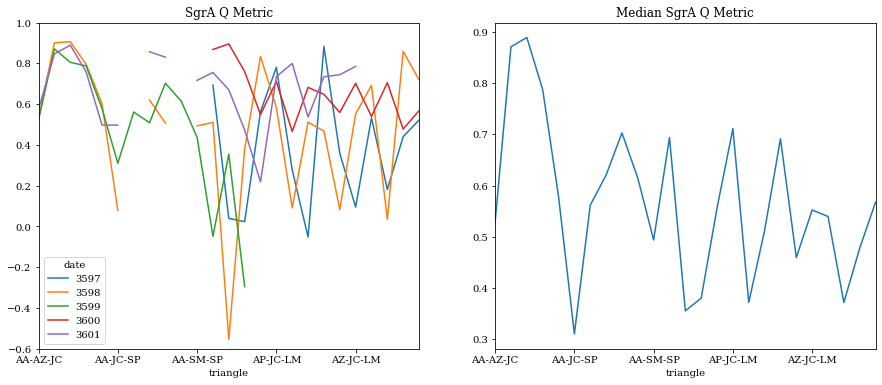

In [54]:
%matplotlib inline
fig, axes = plt.subplots(1,2, figsize=(15,6))
sgra_q_df = qmetric_df.groupby(['triangle', 'date'])['q','dq'].mean().unstack()
sgra_q_df.plot(y='q', title='SgrA Q Metric', ax=axes[0], ylim=[-0.6, 1.0])
qmetric_df.groupby('triangle').q.median().plot(title='Median SgrA Q Metric', ax=axes[1])

## Synthetic data Q-metric

In [3]:
%%capture

uvfolder = os.path.join(
    eht_home, 'SgrA/synthetic_data_SGRA_3599_lo/representative_models/12-Mar-2020-15:21:00/'
)
uvfiles = glob.glob(uvfolder + '*.uvfits')

# Define parameters and compute Q-metric 
params = {'tavg': 120, 'bintime': 0, 'segtime': 0, 'diftime': 0, 'detrend_deg': 3}
qmetric_df_noisy = pd.concat([compute_qmetric_df(uvfile, 3599, **params) for uvfile in uvfiles])

In [109]:
uvfile = uvfiles[0]
with open(uvfolder + 'args.txt', 'r') as file:
    args = json.load(file)
args.pop('fits_path');
envelopes = np.array([envelope.split('/')[-1][:-5] for envelope in args.pop('envelope')])


envelope = envelopes[np.array([uvfile.find(envelope) for envelope in envelopes]) > 0][0]
params = [uvfile.split('.uvfits')[0].split(arg)[1].split('_')[0] for arg in args.keys()]

In [110]:
params

['60.0',
 '19.0',
 'cw',
 '0.1',
 '0.1',
 '0.2',
 '1.0',
 '0.5',
 '0.1',
 '0.3',
 '10.0',
 '0.1',
 '5.0']

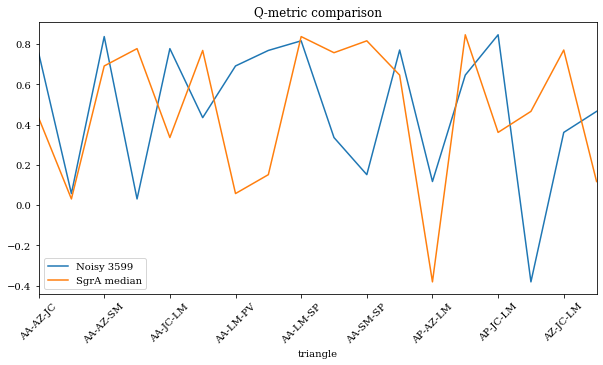

In [19]:
%matplotlib inline
ax = qmetric_df_noisy.plot(x='triangle', y='q', title='Q-metric comparison', legend=False, figsize=(10,5))
qmetric_df.groupby('triangle').q.median().plot(label='SgrA median', ax=ax, legend=False)
plt.xticks(rotation=45)
ax.legend(['Noisy 3599', 'SgrA median'])